This exercise consists of three parts in three notebooks:
1. Graph Cut Segmentation
2. Mean Shift Segmentation
3. Sliding Window Detection

**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. Submit in **teams of 3 or 4 students**, add their names and matriculation numbers below. Only **one team member should upload** the solutions.
2. **Use jupyter notebook**. Other notebook-editing software (e.g. jupyter-lab, pycharm) might corrupt the notebook files and could have issues with displaying matplotlib interactively.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

Team members (names and matriculation numbers):
* 
* 
* 
* 

# Graph Cut Segmentation

In this part you will implement foreground-background segmentation using *Markov random fields* (MRF) and graph cuts.

### Recap from the lecture
A Markov random field is a graphical model that expresses the structure of (input and output) variables. In our image segmentation case this structure means that we do not simply model the foreground and background pixel colors but also take into account the neighborhood relations of the pixels. This encodes the intuition that neighboring pixels are more likely to belong to the same region than just two random pixels of the image.

The color (or more generally, appearance) models and the neighborhood relations are combined in a so-called *energy function* (or cost function), which is then minimized to obtain an optimal label-assignment.

Given a structured input (here: image pixel colors) $\mathcal{Y} = \{Y_j|j \in I\}$ we want to find the output (here: labeling) $\mathcal{X} = \{X_j | j \in I\}$ such that

$$
\hat{\mathcal{X}} = \arg \min_{\mathcal{X}} E(\mathcal{X}, \mathcal{Y})
$$

$$
E(\mathcal{X}, \mathcal{Y}) = \sum_{j\in I}{\psi_u (X_j,Y_j)} + \sum_{i, j\in I}{\psi_p (X_j,X_j,Y_i,Y_j)}.
$$

The set $I$ contains all possible pixel indices. In our two-label (binary) segmentation case, the label variables must be either 0 (background) or 1 (foreground) $X_j \in \{0, 1\}$.

The so-called *unary potential* $\psi_u (X_j,Y_j)$ is the cost of assigning the label $X_j$ to a pixel with color $Y_j$. In probabilistic terms, the unary potential is

$$
\psi_u (X_j,Y_j)=-\omega_u \cdot \log p(X_j|Y_j),
$$

with an appropriate model $p$ for the foreground and the background and a weighting factor $\omega_u$. The unaries encourage labeling each pixel with the label (foreground/background) whose color model is a better fit for that particular pixel.

The *pairwise potential* $\psi_p$ incorporates the dependencies between pixels. To speed up the computation, the pairwise model is usually restricted to neighboring pixels and is therefore set to zero if the $i$th and $j$th pixels are not direct neighbors in a 4-neighborhood. In our case it written as:

$$
\psi_p (X_i,X_j,Y_i,Y_j)=\omega_p\cdot
\begin{cases}
1,&\text{if }   X_i\neq X_j \text{ and } i,j \text{ are neighbors}  \\
0,&\text{otherwise}
\end{cases}
$$

with some weighting factor $\omega_p$. Such a pairwise potential encourages neighboring pixels to have the same label because it gives some nonzero cost to each pair of neighboring pixels that are assigned different labels.

After this, a Graph Cut method is used to find the optimal solution $\hat{\mathcal X}$ of the energy function.

### Bird's eye overview

It's easy to get lost in all the details, so here's an roadmap of what we're going to do:

1. Set up the Markov Random Field (define unaries and pairwise potentials), in more detail:
    1. Manually define some approximate initial background and foreground regions in the image
    2. Model the distribution of background and foreground colors based on the colors found in the approximate initial regions
    3. For each pixel independently, calculate the posterior probability of being foreground, based on the models from the previous step (create a "probability map")
    4. Calculate the unary potentials based on the foreground probability map
    5. Define the pairwise potentials (using the neighborhood relations)
2. Use the graph cut algorithm to minimize the energy function of the Markov Random Field and obtain a labeling

You will not have to implement the graph cut algorithm yourself, we will use the `pygco` ("Python Graph Cut Optimizer") package for that. You can install it using `conda install pygco -c kayarre`. (This is a Python wrapper over the C++ gco library. The C++ library can be found at https://vision.cs.uwaterloo.ca/code/).

In [1]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [4]:
#!conda install -c kayarre pygco


PackagesNotFoundError: The following packages are not available from current channels:

  - pygco

Current channels:

  - https://conda.anaconda.org/kayarre/win-64
  - https://conda.anaconda.org/kayarre/noarch
  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - http://conda.anaconda.org/gurobi/win-64
  - http://conda.anaconda.org/gurobi/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/win-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==5.3.0=py37_0
  - defaults/win-64::astropy==3.0.4=py37hfa6e2cd_0
  - defaults/win-64::bkcharts==0.2=py37_0
  - defaults/win-64::blaze==0.11.3=py37_0
  - defaults/win-64::bokeh==0.13.0=py37_0
  - defaults/win-64::bottleneck==1.2.1=py37h452e1ab_1
  - defaults/win-64::dask==0.19.1=py37_0
  - defaults/win-64::datashape==0.5.4=py37_1
  - defaults/win-64::h5py==2.8.0=py37h3bdd7fb_2
  - defaults/win-64::imageio==2.4.1=py37_0
  - defaults/win-64::matplotlib==2.2.3=py37hd159220_0
  - defaults/win-64::mkl-service==1.1.2=py37hb217b18_5
  - defaults/win-64::mkl_fft==1.0.4=py37h1e22a9b_1
  - defaults/win-64::mkl_random==1.0.1=py37h77b88f5_1
  - defaults/win-64::numba==0.39.0=py37h830ac7b_0
  - defaults/win-64::numexpr==2.6.8=py37h9ef55f4_0
  - defaults/win-64::numpy==1.15.1=py37ha559c80_0
  - defaults/win-6

In [6]:
USE_NETWORKX = True # If you can't get pygco installed, set this to True to use networkx instead.
                      # networkx can also perform the graph cut algorithm, but it is much (!) slower
                      # so try installing pygco first

In [7]:
# Some imports and helper functions
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import time
import cv2
if USE_NETWORKX:
    import networkx as nx
    from networkx.algorithms.flow import preflow_push
else:
    import pygco

def draw_mask_on_image(image, mask, color=(0, 255, 255)):
    """Return a visualization of a mask overlaid on an image."""
    result = image.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, kernel)
    outline = dilated > mask
    result[mask == 1] = (result[mask == 1] * 0.4 + 
                         np.array(color) * 0.6).astype(np.uint8)
    result[outline] = color
    return result

## Mask Initialization

First, manually create initial boxes of foreground and background regions.

We will use these to build color models. That is, to model the probability of a pixel color occuring, given either that it is a foreground or a background pixel.

<IPython.core.display.Javascript object>


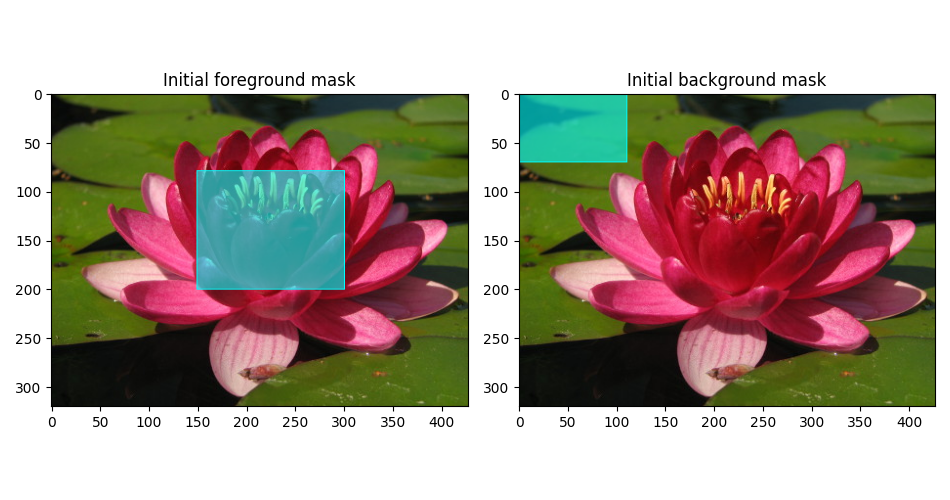

In [67]:
# POINTS: 1

im = imageio.imread('lotus320.jpg')
h,w = im.shape[:2]

# Set up initial foreground and background
# regions for building the color model
init_fg_mask = np.zeros([h, w])
init_bg_mask = np.zeros([h, w])

# Now set some rectangular region of the initial foreground mask to 1.
# This should be a part of the image that is fully foreground.
# The indices in the following line are just an example,
# and they need to be corrected so that only flower pixels are included
# init_fg_mask[10:20, 15:30] = 1

# Same for the background (replace the indices)
# init_bg_mask[60:90, 50:110] = 1

# YOUR CODE HERE
#raise NotImplementedError()
init_fg_mask[80:200, 150:300] = 1
init_bg_mask[0:70, 0:110] = 1

fig, axes = plt.subplots(1, 2, figsize=(9.5,5))
axes[0].set_title('Initial foreground mask')
axes[0].imshow(draw_mask_on_image(im, init_fg_mask))
axes[1].set_title('Initial background mask')
axes[1].imshow(draw_mask_on_image(im, init_bg_mask))
fig.tight_layout()
fig.show()

## Color Modeling by Histograms

A common way to model color distributions is to use *Gaussian mixture models*. However, to keep this exercise simple, we will only use color histograms (i.e. the relative frequencies of quantized colors) in the respective region of the image defined by the boxes. In other words, we model the color simply as a discretized, categorical random variable.

Implement the function `calculate_histogram`. It should take as input the image `im` with values in the range $[0, 255]$ and a `mask` the same size as the image. The mask is 1 at the positions of the image where the histogram should be computed, zero elsewhere. The final parameter `n_bins` defines how many bins should be used in the histogram along each dimension. The function should **return a 3-dimensional array** of shape `[n_bins, n_bins, n_bins]`, containing the relative frequency for each `(r, g, b)` color bin within the region of the image defined by the mask, i.e. the fraction of pixels falling within each bin. The histogram should be normalized (sum to 1). All bins are initialized with a small value ($10^{−3}$) to avoid relative frequencies which are zero. (Why would zeros be a problem?)

In [89]:
#added
def split(a, n):
    k, m = divmod(len(a), n)
    return (list(a[i*k+min(i, m):(i+1)*k+min(i+1, m)]) for i in range(n))

In [36]:
#added
def get_mask_index(mask):
    min_x = np.nonzero(mask)[0][0]
    max_x = np.nonzero(mask)[0][-1]
    min_y = np.nonzero(mask)[1][0]
    max_y = np.nonzero(mask)[1][-1]

    return (min_x,max_x,min_y,max_y)

In [150]:
def get_bin_idx(n_bins, l):
    bins = list(split(range(256), n_bins))
    
    r,g,b = l 
        
    for i, bin_idx in enumerate(bins):
            if r in bin_idx:
                r_bin = i
            if g in bin_idx:
                g_bin = i
            if b in bin_idx:
                b_bin = i
    return r_bin, g_bin, b_bin

In [149]:
# POINTS: 3

def calculate_histogram(im, mask, n_bins):
    histogram = np.full((n_bins, n_bins, n_bins), fill_value=0.001)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    #bins = list(split(range(256), n_bins))
    (min_x,max_x,min_y,max_y) = get_mask_index(mask)
    img_box = im[min_x:max_x+1, min_y:max_y+1].reshape(-1,3)
    for l in img_box:
        r_bin, g_bin, b_bin = get_bin_idx(n_bins, l)
        histogram[r_bin][g_bin][b_bin] += 1

    histogram = histogram / histogram.sum(-1).sum(-1).sum(-1) #NORMALIZATION 
    
    return histogram

<IPython.core.display.Javascript object>


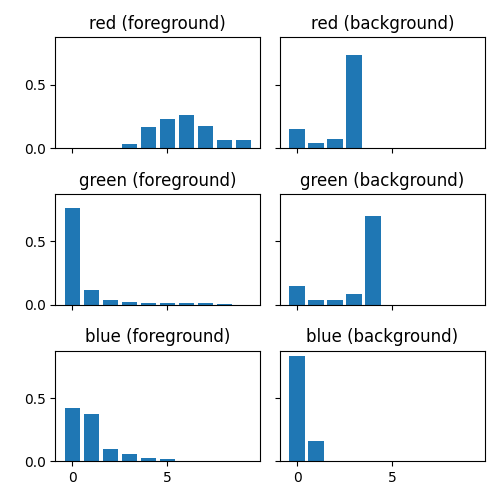

In [135]:
n_bins = 10
fg_histogram = calculate_histogram(im, init_fg_mask, n_bins)
bg_histogram = calculate_histogram(im, init_bg_mask, n_bins)

fig, axes = plt.subplots(
    3, 2, figsize=(5,5), sharex=True, 
    sharey=True, num='Relative frequency of color bins')

x = np.arange(n_bins)
axes[0,0].bar(x, np.sum(fg_histogram, (1, 2)))
axes[0,0].set_title('red (foreground)')
axes[1,0].bar(x, np.sum(fg_histogram, (0, 2)))
axes[1,0].set_title('green (foreground)')
axes[2,0].bar(x, np.sum(fg_histogram, (0, 1)))
axes[2,0].set_title('blue (foreground)')

axes[0,1].bar(x, np.sum(bg_histogram, (1, 2)))
axes[0,1].set_title('red (background)')
axes[1,1].bar(x, np.sum(bg_histogram, (0, 2)))
axes[1,1].set_title('green (background)')
axes[2,1].bar(x, np.sum(bg_histogram, (0, 1)))
axes[2,1].set_title('blue (background)')
fig.tight_layout()
fig.show()

How does the histogram calculation in `calculate_histogram` differ from creating 3 separate histograms, for R, G, and B individually? Would this alternative method (separate histograms) yield more or or less information about the image?

*POINTS: 0*

it would yield less information. It would just tell us the frequency of each r ,g,b color seperately. While the 3D method tells us the frequeny of each color value considering the other two color values.

## Foreground Probability Map

The next step in the segmentation process is to estimate a probability map: For each pixel we want to estimate the probability that it belongs to the foreground. This will be used as basis for the unary potential.

The function `foreground_pmap(im, fg_histogram, bg_histogram)` should take the image `im` and the two histograms `fg_histogram`, `bg_histogram` estimated from the foreground region and the background region respecively. It should return an array of shape $\texttt{height}\times\texttt{width}$ containing the probability of each pixel belonging to the foreground. To estimate the required probability $p(c|[r, g, b])$ from the computed histograms, a class prior $p(c)$ of $0.5$ should be used, which means that both foreground and background pixels are equally likely a priori. 

Recall Bayes' theorem applied to this case:

$$
p(c\ |\ r,g,b) = \frac{p(c) \cdot p(r,g,b\ |\ c)}{p(r,g,b)} = \frac{p(c)\cdot p(r,g,b\ |\ c)}{\sum_{\tilde{c}} p(\tilde{c}) \cdot p(r,g,b\ |\ \tilde{c}) }
$$

In [155]:
# POINTS: 4

def foreground_pmap(im, fg_histogram, bg_histogram):
    # YOUR CODE HERE
    prior = 0.5
    probs = np.zeros((im.shape[0],im.shape[1]))
    #raise NotImplementedError()
    for i, row in enumerate(im):
        for j, col in enumerate(row):
            r,g,b = get_bin_idx(n_bins, col)
            numerator = prior * fg_histogram[r][g][b]
            denominator = numerator + prior * bg_histogram[r][g][b]
            res = numerator / denominator
            probs[i,j] = res
    return probs
    

<IPython.core.display.Javascript object>


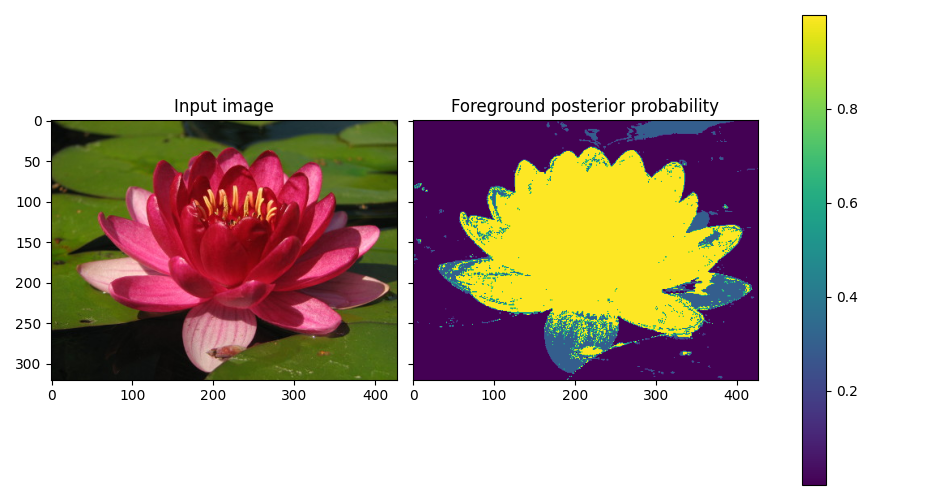

In [156]:
foreground_prob = foreground_pmap(im, fg_histogram, bg_histogram)
fig, axes = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
axes[0].imshow(im)
axes[0].set_title('Input image')
im_plot = axes[1].imshow(foreground_prob, cmap='viridis')
axes[1].set_title('Foreground posterior probability')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)
foreground_map = (foreground_prob > 0.5)
fig.show()

Explain what you see in the probability map.

*POINTS: 0*

YOUR ANSWER HERE

## Unary Potentials
Use the previously computed probability map `foreground_map` to compute the unary potential for both foreground and background.

This function `unary_potentials(probability_map, unary_weight)` shall use the `probability_map` and a scalar weighting factor to compute the unary potentials. It should return a matrix of the same size as the probability matrix.

<IPython.core.display.Javascript object>


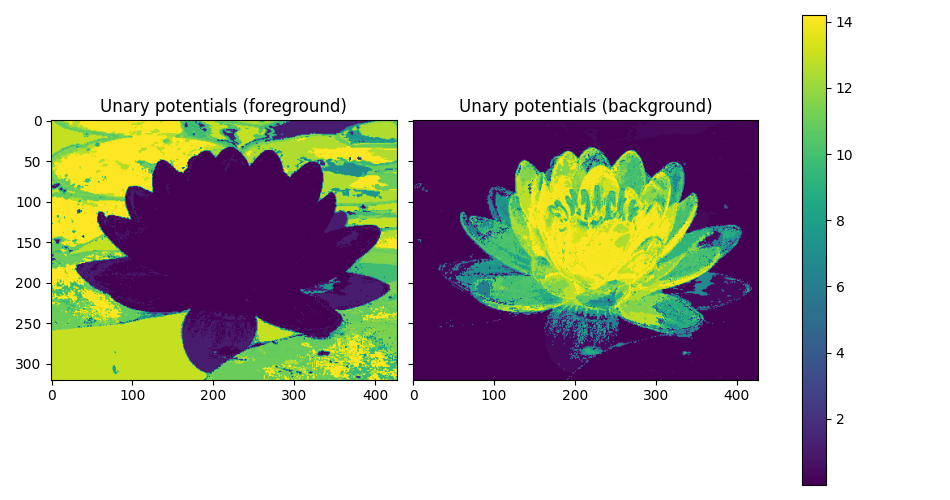

In [158]:
# POINTS: 1

def unary_potentials(probability_map, unary_weight):
    # YOUR CODE HERE
    #raise NotImplementedError()
   
    return -unary_weight*np.log(probability_map)
    
unary_weight = 1
unary_fg = unary_potentials(foreground_prob, unary_weight)
unary_bg = unary_potentials(1 - foreground_prob, unary_weight)
fig, axes = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
axes[0].imshow(unary_fg)
axes[0].set_title('Unary potentials (foreground)')
im_plot = axes[1].imshow(unary_bg)
axes[1].set_title('Unary potentials (background)')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)
fig.show()

Why are the unary potentials for the foreground so small in the middle of the flower?

*POINTS: 0*

YOUR ANSWER HERE

## Pairwise Potentials

Create a function to compute the prefactor $w_p$ of the pairwise potential for two specific pixels. Implement the function below, where `im` is the image, `(x1, y1), (x2, y2)` are the pixel coordinates in the image and the last parameter is the weight $\omega_p$ for the pairwise potential. (Do not confuse `(x1, y1), (x2, y2)` with the $X_j, Y_j$ from the top of the page. There $\mathcal X$ was the label and $\mathcal Y$ the pixel value, here they are the $x$ and $y$ coordinates in the image) 

Keep in mind that this prefactor does not depend on the labels and is therefore independent of $\mathcal{X}$. The function signature is more general (see the contrast-sensitive Potts Model question later on), not all parameters are needed here. Note, that it is not computed here whether the given pixels are neighbours, as this is not part of the prefactor $\omega_p$.

*Hint:* the function is extremely simple.

In [170]:
# POINTS: 1

def pairwise_potential_prefactor(im, x1, y1, x2, y2, pairwise_weight):
    # YOUR CODE HERE
    #raise NotImplementedError()

    if im[x1,y1][0] != im[x2,y2][0]:
        if (x1+1,y1)==(x2,y2) or (x1-1,y1)==(x2,y2) or (x1,y1+1)==(x2,y2) or (x1,y1-1)==(x2,y2): #neighbours
            return pairwise_weight
        else: return 0
    else: return 0

Using the functions from the previous task, implement a function to compute all the pairwise potentials for the image using 4-neighborhoods. That means only the top, bottom, left and right neighboring pixels should be connected to a given pixel.

The function `pairwise_potentials` should return the `edges` (represented as index pairs) and an array `costs` containing the corresponding edge costs (i.e. the value of the pairwise potential prefactor). You have to use a linearized index instead of (x,y)-coordinates for the edge indices. A conversion function is supplied (`coords_to_index(x, y, width)`).

Thus, `edges` should be an integer array of shape $k\times 2$, while `costs` should have length $k$, where $k$ is the number of neighborhood-edges in the image grid.

In [175]:
# POINTS: 4

def coords_to_index(x, y, width):
    return y * width + x

def pairwise_potentials(im, pairwise_weight):
    # YOUR CODE HERE
    #raise NotImplementedError()
    edges = []
    costs = []
    width = 1 #?
    max_x, max_y = im.shape[:2]
    for i, row in enumerate(im):
        for j, col in enumerate(row):
            source_idx = coords_to_index(i,j,width)
            if i+1 < max_x:
                target_idx = coords_to_index(i+1,j,width)
                edges.append([source_idx,target_idx])
                costs.append(pairwise_potential_prefactor(im, i, j, i+1, j, pairwise_weight))
                
            if i-1 >= 0:
                target_idx = coords_to_index(i-1,j,width)
                edges.append([source_idx,target_idx])
                costs.append(pairwise_potential_prefactor(im, i, j, i-1, j, pairwise_weight))
                
            if j+1 < max_y:
                target_idx = coords_to_index(i,j+1,width)
                edges.append([source_idx,target_idx])
                costs.append(pairwise_potential_prefactor(im, i, j, i, j+1, pairwise_weight))
                
            if j-1 >= 0:
                target_idx = coords_to_index(i,j-1,width)
                edges.append([source_idx,target_idx])
                costs.append(pairwise_potential_prefactor(im, i, j, i, j-1, pairwise_weight))
        
    return edges, costs

pairwise_edges, pairwise_costs = pairwise_potentials(im, pairwise_weight=10) #change weightfor e-test

Now you can execute the optimization procedure and plot the resulting labeling.

<ipython-input-176-b4f56245a1a8>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.zeros_like(unary_fg, dtype=np.int)


<IPython.core.display.Javascript object>


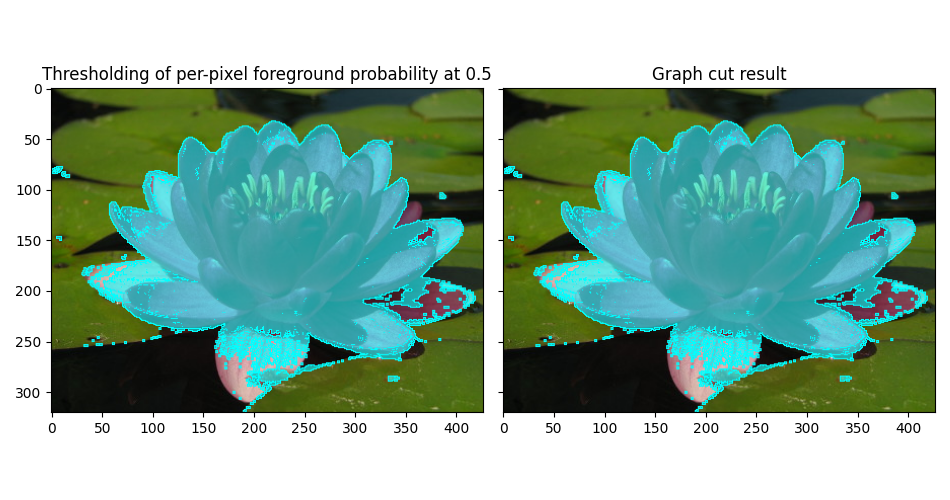

In [176]:
def graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs):
    if USE_NETWORKX:

        graph = nx.Graph()
        s = object()
        t = object()

        edges = []
        for i, cost in enumerate(unary_bg.flat):
            edges.append((s, i, cost))
        for i, cost in enumerate(unary_fg.flat):
            edges.append((i, t, cost))
        for (i,j), cost in zip(pairwise_edges, pairwise_costs):
            edges.append((i, j, cost))

        graph.add_weighted_edges_from(edges, 'capacity')

        nodes_connected_to_s = nx.minimum_cut(
            graph, s, t, flow_func=preflow_push)[1][0]

        fg_pixel_indices = list(set(nodes_connected_to_s) - {s})
        labels = np.zeros_like(unary_fg, dtype=np.int)
        labels.flat[fg_pixel_indices] = 1
        return labels
    else:
        unaries = np.stack([unary_bg.flat, unary_fg.flat], axis=-1)
        labels = pygco.cut_general_graph(
            pairwise_edges, pairwise_costs, unaries, 
            1-np.eye(2), n_iter=-1, algorithm='swap')
        return labels.reshape(unary_fg.shape)

graph_cut_result = graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)
fig, axes = plt.subplots(1, 2, figsize=(9.5,5), sharey=True)
axes[0].set_title('Thresholding of per-pixel foreground probability at 0.5')
axes[0].imshow(draw_mask_on_image(im, foreground_prob>0.5))
axes[1].set_title('Graph cut result')
axes[1].imshow(draw_mask_on_image(im, graph_cut_result))
fig.tight_layout()
fig.show()

Explain what you see. Why is the segmentation the way it is? What happens if you change the pairwise weight in the previous cell?

*POINTS: 0*

YOUR ANSWER HERE

## [OPTIONAL] Try another image

First, create a single function that runs the whole segmentation pipeline starting from the image and the initial regions.

`segment_image(...)` should return the final binary segmentation mask with 1 at the foreground pixels and 0 at the background.

In [ ]:
# POINTS: 0

def segment_image(im, init_fg_mask, init_bg_mask,
                  unary_weight, pairwise_weight, n_bins):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# POINTS: 0

import skimage.data

def run_on_another_image():
    im = skimage.data.immunohistochemistry()
    #im = imageio.imread('flowers.jpg')
    #im = skimage.data.stereo_motorcycle()[0]
    h, w = im.shape[:2]
    fg_mask = np.zeros([h, w])
    bg_mask = np.zeros([h, w])

    # Set some appropriate parts of fg_mask and bg_mask to 1 for initialization.
    # YOUR CODE HERE
    raise NotImplementedError()

    graph_cut_result = segment_image(
        im, fg_mask, bg_mask, 
        unary_weight=1, pairwise_weight=1, n_bins=8)
    
    fig, axes = plt.subplots(1, 3, figsize=(9.5,5), sharey=True)
    axes[0].set_title('Initial foreground mask')
    axes[0].imshow(draw_mask_on_image(im, fg_mask))
    axes[1].set_title('Initial background mask')
    axes[1].imshow(draw_mask_on_image(im, bg_mask))
    axes[2].set_title('Graph cut result')
    axes[2].imshow(draw_mask_on_image(im, graph_cut_result))
    fig.tight_layout()
    fig.show()
    
run_on_another_image()

Does it look good? Which parameter would you need to change to reduce the number of holes in the segmentation? Try it.

Now try segmenting `im = skimage.data.stereo_motorcycle()[0]` using this technique. Can you segment out the motorbike by fiddling with the parameters? Why or why not?

*POINTS: 0*

YOUR ANSWER HERE

## [OPTIONAL] Contrast-Sensitive Potts Model
Go back to the `pairwise_potential_prefactor` function and modify it to incorporate a new term, resulting in the so-called *contrast sensitive Potts model*. The new pairwise potential should be:

$$
\psi_p (X_i,X_j,Y_i,Y_j,i,j)=\omega_p\cdot \exp\left(-\omega_d\|Y_i - Y_j\|^2\right)\cdot 
\begin{cases}
1,&\text{if } X_i \neq X_j \text{ and } i,j \text{ are neighbors}  \\
0,&\text{otherwise}
\end{cases}
$$

This means the prefactor is now $\omega_p\cdot \exp\left(-\omega_d\|Y_i - Y_j\|^2\right)$. For simplicity, you can hardcode the parameter $\omega_d$. 

What changes when using the contrast sensitive Potts model? What is the intuition behind adding this new term?

*POINTS: 0*

YOUR ANSWER HERE

## [OPTIONAL] Iterative Segmentation

We can make the result better if we iterate the labeling process several times. Implement `iterative_opt`, a method to execute the optimization process iteratively. 

Use the previously computed labeling as initial segmentation (instead of the rectangular masks we used above) and estimate new models (histograms and unaries) for foreground and background based on these. Solve the graph cut problem and use the resulting segmentation in the next iteration.

In [ ]:
# POINTS: 0

def iterative_opt(im, fg_mask, n_bins, unary_weight,
                  pairwise_edges, pairwise_costs, n_iter):
    # YOUR CODE HERE
    raise NotImplementedError()

labels_5 = iterative_opt(
    im, graph_cut_result, n_bins, unary_weight, pairwise_edges, pairwise_costs, n_iter=5)
labels_10 = iterative_opt(
    im, labels_5, n_bins, unary_weight, pairwise_edges, pairwise_costs, n_iter=5)

fig, axes = plt.subplots(1, 3, figsize=(9.5,4), sharex=True, sharey=True)
axes[0].set_title('Initial')
axes[0].imshow(draw_mask_on_image(im, graph_cut_result))
axes[1].set_title(f'After 5 iterations')
axes[1].imshow(draw_mask_on_image(im, labels_5))
axes[2].set_title(f'After 10 iterations')
axes[2].imshow(draw_mask_on_image(im, labels_10))
fig.tight_layout()
fig.show()

How did the labeling change? Do you have an explanation why?

*POINTS: 0*

YOUR ANSWER HERE

## [OPTIONAL] Interactive Segmentation

We can get even better results by incorporating user input into the iterative segmentation process you implemented above.

Extend the given framework to allow the user to add or remove rectangular regions from the graph cut result. Then recalculate the foreground and background model according to new mask. Iterate this process until the user is satisfied with the result.

For this, look up how to create interactive graphical interfaces using Matplotlib, see for example `matplotlib.widgets.RectangleSelector` and `matplotlib.widgets.Button`.

In [ ]:
# POINTS: 0

# YOUR CODE HERE
raise NotImplementedError()